In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

import cartopy as cart
import cartopy.crs as ccrs
import cmocean.cm as cmo
import seaborn as sns
from glob import glob
import cartopy.feature as cfeature
import pandas as pd

In [2]:
simulations = pd.read_csv('../log_simulationsV2.csv', index_col=1)

In [3]:
simulations.head()

,Unnamed: 0,test_run,date,depth,lon,lat,start_time,sim_time,diameter,density,diffusion,sinking_vel,fragmentation,frag_timescale,frag_mode,bio_fields
ID,,,,,,,,,,,,,,,,
NSCXZ4,0,True,2022-06-28 10:35:42.485040,5000,6.287,-32.171,2019-12-30 12:00:00,10,5.000000e-08,1380,False,True,True,100,0.5,False
W91LG6,0,True,2022-06-28 10:45:03.641050,5000,6.287,-32.171,2019-12-30 12:00:00,10,5.000000e-08,1380,False,True,True,100,0.5,False
Y5NZSV,0,True,2022-06-28 10:46:59.725091,5000,6.287,-32.171,2019-12-30 12:00:00,10,5.000000e-08,1380,False,True,False,100,0.5,False
5HDFET,0,True,2022-06-28 11:10:22.819588,5000,6.287,-32.171,2019-12-30 12:00:00,10,5.000000e-08,1380,False,True,True,100,0.5,False
T1E76A,0,True,2022-06-28 11:47:13.766923,5000,6.287,-32.171,2019-12-30 12:00:00,10,5.000000e-08,1380,False,True,True,100,0.5,False


In [4]:
simulations.loc['1AYNSB']

Unnamed: 0                                 0
test_run                               False
date              2022-07-06 17:38:27.308957
depth                                   5000
lon                                    6.287
lat                                  -32.171
start_time               2019-12-30 12:00:00
sim_time                                3650
diameter                                 0.0
density                                 1380
diffusion                               True
sinking_vel                             True
fragmentation                           True
frag_timescale                           100
frag_mode                                0.5
bio_fields                             False
Name: 1AYNSB, dtype: object

In [5]:
path = '/storage/shared/oceanparcels/output_data/data_Claudio/set_10/'

names = ['1R6BXC', 'WSHL2Y', 'J3P65H', 'RNZDTK', 'M3T1VP', '6315NU', '5630FQ']

data = {}

for i in names:
    ID = 'ft' + str(simulations.loc[i]['frag_timescale'])

#     print(ID, serial)
    print(f'/storage/shared/oceanparcels/output_data/data_Claudio/set_10/{i}.zarr/')
    data[ID] = xr.open_zarr(f'/storage/shared/oceanparcels/output_data/data_Claudio/set_10/{i}.zarr/')


/storage/shared/oceanparcels/output_data/data_Claudio/set_10/1R6BXC.zarr/
/storage/shared/oceanparcels/output_data/data_Claudio/set_10/WSHL2Y.zarr/
/storage/shared/oceanparcels/output_data/data_Claudio/set_10/J3P65H.zarr/
/storage/shared/oceanparcels/output_data/data_Claudio/set_10/RNZDTK.zarr/
/storage/shared/oceanparcels/output_data/data_Claudio/set_10/M3T1VP.zarr/
/storage/shared/oceanparcels/output_data/data_Claudio/set_10/6315NU.zarr/
/storage/shared/oceanparcels/output_data/data_Claudio/set_10/5630FQ.zarr/


In [26]:
data['ft100']

<xarray.Dataset>
Dimensions:           (traj: 10000, obs: 909)
Dimensions without coordinates: traj, obs
Data variables: (12/14)
    Kz                (traj, obs) float32 dask.array<chunksize=(1250, 228), meta=np.ndarray>
    abs_salinity      (traj, obs) float32 dask.array<chunksize=(1250, 228), meta=np.ndarray>
    cons_temperature  (traj, obs) float32 dask.array<chunksize=(1250, 228), meta=np.ndarray>
    density           (traj, obs) float32 dask.array<chunksize=(1250, 228), meta=np.ndarray>
    diameter          (traj, obs) float32 dask.array<chunksize=(1250, 228), meta=np.ndarray>
    lat               (traj, obs) float64 dask.array<chunksize=(1250, 114), meta=np.ndarray>
    ...                ...
    seafloor          (traj, obs) float32 dask.array<chunksize=(1250, 228), meta=np.ndarray>
    time              (traj, obs) datetime64[ns] dask.array<chunksize=(1250, 114), meta=np.ndarray>
    trajectory        (traj, obs) float64 dask.array<chunksize=(1250, 114), meta=np.ndarray>
    v_s               (traj, obs) float32 dask.array<chunksize=(1250, 228), meta=np.ndarray>
    w                 (traj, obs) float32 dask.array<chunksize=(1250, 228), meta=np.ndarray>
    z                 (traj, obs) float64 dask.array<chunksize=(1250, 114), meta=np.ndarray>
Attributes:
    Conventions:            CF-1.6/CF-1.7
    feature_type:           trajectory
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_mesh:           spherical
    parcels_version:        v2.3.0-239-g31f81d51

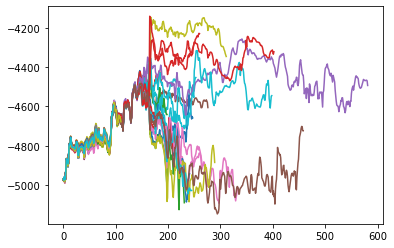

In [9]:
for i in range(0, 10000, 100):
    plt.plot(data['ft100']['mld'][i,:] - data['ft100']['z'][i,:])

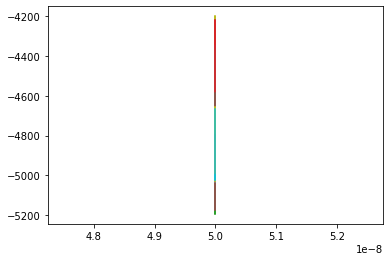

In [29]:
for i in range(0, 10000, 100):
    plt.plot(data['ft100']['diameter'][i,:], -data['ft100']['z'][i,:])

In [60]:
test = xr.open_zarr('/storage/shared/oceanparcels/output_data/data_Claudio/tests/testxx.zarr/')

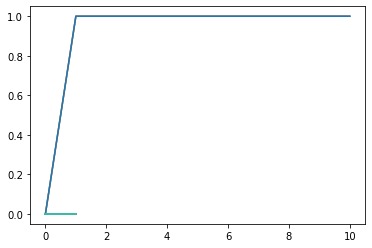

In [61]:
for i in range(0, 100, 1):
    plt.plot(test['surface'][i,:])

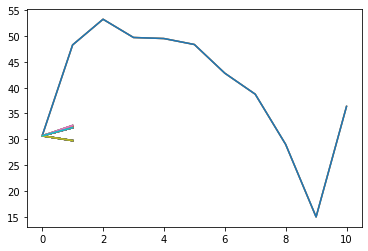

In [62]:
for i in range(0, 100, 1):
    plt.plot(test['mld'][i,:])

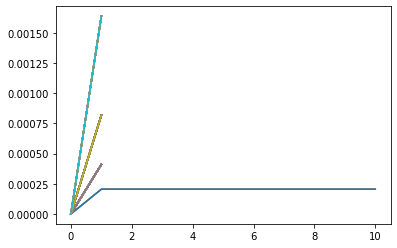

In [63]:
for i in range(0, 100, 1):
    plt.plot(test['diameter'][i,:])

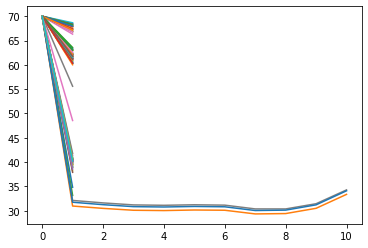

In [64]:
for i in range(0, 100, 1):
    plt.plot(test['true_z'][i,:])
#     plt.plot(test['mld'][i,:])

In [77]:
max(test['diameter'][i,:].values)

0.0008192

In [78]:
min(test['diameter'][i,:].values)

5e-08

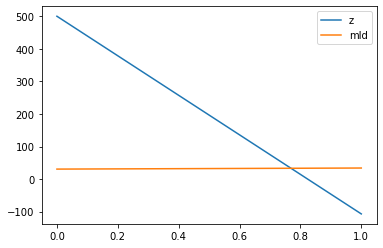

In [84]:
plt.plot(test['z'][0,:], label='z')
plt.plot(test['mld'][0,:], label='mld')
plt.legend()
    

(array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]),
 array([-4.9999994e-01, -3.9999995e-01, -2.9999995e-01, -1.9999994e-01,
        -9.9999949e-02,  5.0000001e-08,  1.0000005e-01,  2.0000005e-01,
         3.0000004e-01,  4.0000004e-01,  5.0000006e-01], dtype=float32),
 <BarContainer object of 10 artists>)

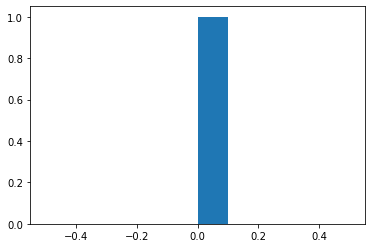

In [12]:
plt.hist(data['diameter'][:, 900])

In [40]:
data

<xarray.Dataset>
Dimensions:           (traj: 10000, obs: 1826)
Dimensions without coordinates: traj, obs
Data variables: (12/14)
    Kz                (traj, obs) float32 dask.array<chunksize=(1250, 229), meta=np.ndarray>
    abs_salinity      (traj, obs) float32 dask.array<chunksize=(1250, 229), meta=np.ndarray>
    cons_temperature  (traj, obs) float32 dask.array<chunksize=(1250, 229), meta=np.ndarray>
    density           (traj, obs) float32 dask.array<chunksize=(1250, 229), meta=np.ndarray>
    diameter          (traj, obs) float32 dask.array<chunksize=(1250, 229), meta=np.ndarray>
    lat               (traj, obs) float64 dask.array<chunksize=(625, 229), meta=np.ndarray>
    ...                ...
    seafloor          (traj, obs) float32 dask.array<chunksize=(1250, 229), meta=np.ndarray>
    time              (traj, obs) datetime64[ns] dask.array<chunksize=(625, 229), meta=np.ndarray>
    trajectory        (traj, obs) float64 dask.array<chunksize=(625, 229), meta=np.ndarray>
    v_s               (traj, obs) float32 dask.array<chunksize=(1250, 229), meta=np.ndarray>
    w                 (traj, obs) float32 dask.array<chunksize=(1250, 229), meta=np.ndarray>
    z                 (traj, obs) float64 dask.array<chunksize=(625, 229), meta=np.ndarray>
Attributes:
    Conventions:            CF-1.6/CF-1.7
    feature_type:           trajectory
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_mesh:           spherical
    parcels_version:        v2.3.0-239-g31f81d51

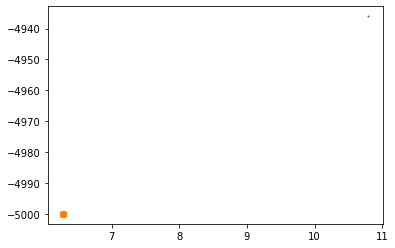

In [16]:
# plt.scatter(data['lon'][:, 1800], -data['z'][:, 1800], s=1)
# plt.scatter(data['lon'][:, 1000], -data['z'][:, 1000], s=1)
plt.scatter(data['lon'][:, 908], -data['z'][:, 500], s=1)
plt.scatter(data['lon'][:, 0], -data['z'][:, 0])


In [57]:
for n_day in range(1800, 0, -200):
    print(n_day)

1800
1600
1400
1200
1000
800
600
400
200


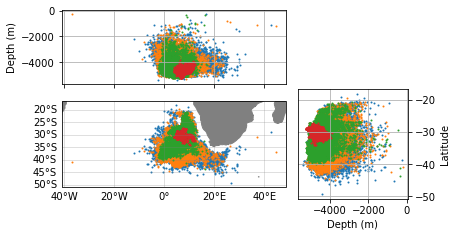

In [64]:
frame = 0
n_day = 1000
size_point = 1
fig = plt.figure(figsize=(6,4))
gs = fig.add_gridspec(3, 2,  width_ratios=(6.1, 3), height_ratios=(2, 3, 1),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.07, hspace=0.07)

ax = plt.subplot(gs[1, 0], projection=ccrs.PlateCarree())
# ax.set_extent((-45, 46, -52, -16))
ax.add_feature(cfeature.LAND,facecolor='#808080', zorder=1)
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=0.5, color='gray', alpha=0.5)
gl.right_labels = False
gl.top_labels = False

ax_lon = plt.subplot(gs[0, 0], sharex=ax)
ax_lon.grid()
ax_lon.set_xticklabels([])
ax_lon.set_ylabel('Depth (m)')
# ax_lon.set_ylim(-2000, 0)


ax_lat = fig.add_subplot(gs[1, 1])
ax_lat.grid()

# ax_lat.scatter(sim_['abs_salinity'], sim_['cons_temperature'], s=1, c=-sim_['depth']);
# ax_lat.set_xlim(33, max_sal + 1)
ax_lat.yaxis.tick_right()
ax_lat.yaxis.set_label_position("right")
# cs = ax_TS.contour(Sg, Tg, sigma_theta, colors='k', zorder=1)
# cl = plt.clabel(cs, fontsize=10, inline=False, fmt='%.1f')

ax_lat.set_xlabel('Depth (m)')
ax_lat.set_ylabel('Latitude')

# size_point = 0.7
for n_day in range(1800, 0, -500):
    im = ax.scatter(data['lon'][:, n_day], data['lat'][:, n_day],  s=size_point)
    ax_lon.scatter(data['lon'][:, n_day], -data['z'][:, n_day], s=size_point)
    ax_lat.scatter(-data['z'][:, n_day], data['lat'][:, n_day], s=size_point);
# # ax_lat.scatter(-sim_['depth'], sim_['lat'], c=-sim_['depth'], s=size_point)

# bar_ax = fig.add_axes([0.12, 0.12, 0.52, 0.05])
# plt.colorbar(im, cax=bar_ax, orientation='horizontal', label='Final depth (m)')


In [59]:
1800/365

4.931506849315069

(array([8297.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        1673.]),
 array([0.0e+00, 5.0e-09, 1.0e-08, 1.5e-08, 2.0e-08, 2.5e-08, 3.0e-08,
        3.5e-08, 4.0e-08, 4.5e-08, 5.0e-08], dtype=float32),
 <BarContainer object of 10 artists>)

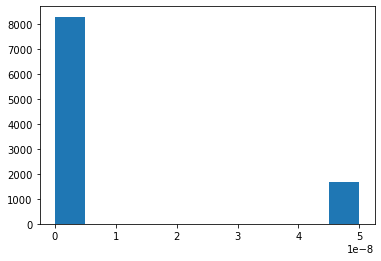

In [21]:
plt.hist(data['diameter'][:, -1])